In [9]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.9.1


In [10]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [11]:
def create_label_colormap():
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [12]:
MODEL = DeepLabModel(r"C:\Users\sakth\PycharmProjects\python-projects\palan_project\projects\INTERNSHIP PROJECTS\environment detection and segmentation\deeplab_model.tar.gz")
print('model loaded successfully!')

model loaded successfully!


### Run on the sample image
The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset.

running deeplab on the sample image...


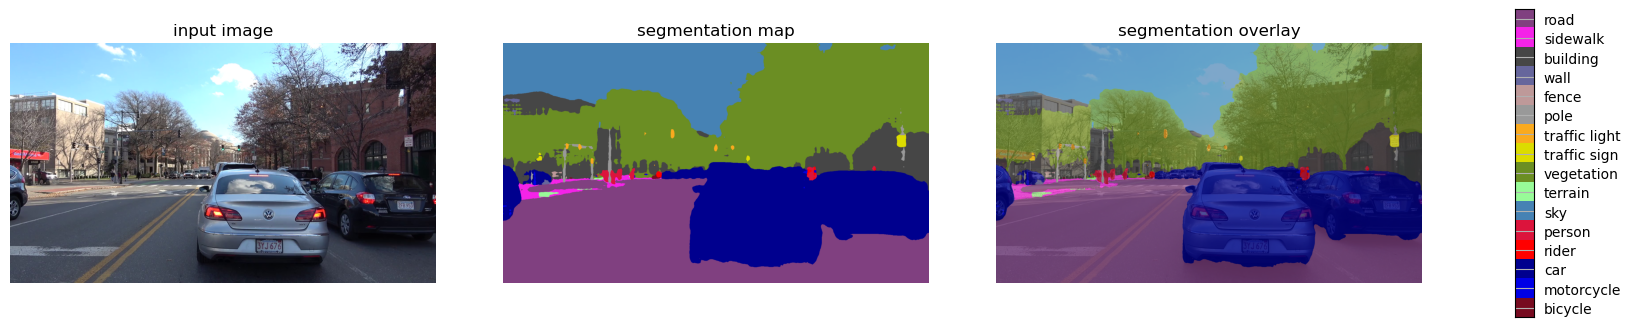

In [13]:
SAMPLE_IMAGE = r'C:\Users\sakth\PycharmProjects\python-projects\palan_project\projects\INTERNSHIP PROJECTS\environment detection and segmentation\environment_detection_and_segmentation.png'
print('running deeplab on the sample image...')

run_visualization(SAMPLE_IMAGE)

### Run on the sample video
The sample video is frame #0 to #597 in the MIT DriveSeg Dataset.

In [14]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)


SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

running deeplab on the sample video...


### Evaluation
Now let's evaluate the model performance with the ground truth annotation. First read the annotation from a tar file.

In [15]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt

SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

FileNotFoundError: [Errno 2] No such file or directory: 'mit_driveseg_sample_gt.tar.gz'

### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [ ]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))